In [ ]:
# default_exp dataloaders

# DataLoaders

> Preprocessing and loading data for DL models.

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
from steel_segmentation.core import *
from steel_segmentation.data import *

from fastcore.test import *
from fastai.vision.all import *
from PIL import Image
from collections import defaultdict
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

In [ ]:
# hide
only_imgs = ["0a1cade03.jpg", "bca4ae758.jpg", "988cf521f.jpg", "b6a257b28.jpg",
             "b2ad335bf.jpg", "72aaba8ad.jpg", "f383950e8.jpg"]
train = train[train["ImageId"].isin(only_imgs)].copy()
train_all = train_all[train_all["ImageId"].isin(only_imgs)].copy()
train_multi = train_multi[train_multi["ImageId"].isin(only_imgs)].copy()

In this module you can have functions for a classification and a segmentation problem. 

## Classification

Starting with a classification task, with the `DataBlock` API of *fast.ai* we can build in a easy way a training and validation dataset inside a `Datasets` fastai class.

In [ ]:
#hide
size = None

In [ ]:
b_tfms = aug_transforms(
            size=size if size else (256, 1600),
            max_warp=0.,
            flip_vert=True,
            max_rotate=5.,
            max_lighting=0.1)

In [ ]:
b_tfms

[Dihedral -- {'size': (256, 1600), 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.1, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ]

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock()),
    get_x=ColReader(0, pref=train_path),
    get_y=ColReader(1, label_delim=' '),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    batch_tfms=b_tfms)

Now we can check that all is alright passing a `source` into the `dblock` and the API returns all the process explained.

Setting-up type transforms pipelines
0        0002cc93b.jpg             1
1        00031f466.jpg             0
2        000418bfc.jpg             0
3        000789191.jpg             0
4        0007a71bf.jpg             3
...                ...           ...
12563    fff0295e1.jpg             0
12564    fff02e9c5.jpg             3
12565    fffe98443.jpg             3
12566    ffff4eaa8.jpg             3
12567    ffffd67df.jpg             3

[12568 rows x 2 columns]
Found 12568 items
2 datasets of sizes 10055,2513
Setting up Pipeline: ColReader -- {'cols': 0, 'pref': Path('../data/train_images'), 'suff': '', 'label_delim': None} -> PILBase.create
Setting up Pipeline: ColReader -- {'cols': 1, 'pref': '', 'suff': '', 'label_delim': ' '} -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: ColReader -- {'cols': 0, 'pref': Path('../data/train_images'), 'suff': '', 'label_delim': None} -> PILBase.create
    start

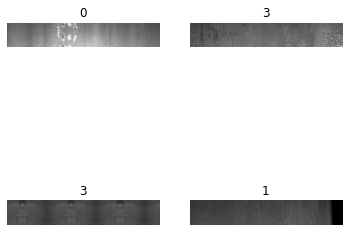

In [ ]:
dblock.summary(train_multi, show_batch=True)

And then we can create a `Datasets` class.

In [ ]:
dsets = dblock.datasets(train_multi, verbose=True)

0        0002cc93b.jpg             1
1        00031f466.jpg             0
2        000418bfc.jpg             0
3        000789191.jpg             0
4        0007a71bf.jpg             3
...                ...           ...
12563    fff0295e1.jpg             0
12564    fff02e9c5.jpg             3
12565    fffe98443.jpg             3
12566    ffff4eaa8.jpg             3
12567    ffffd67df.jpg             3

[12568 rows x 2 columns]
Found 12568 items
2 datasets of sizes 10055,2513
Setting up Pipeline: ColReader -- {'cols': 0, 'pref': Path('../data/train_images'), 'suff': '', 'label_delim': None} -> PILBase.create
Setting up Pipeline: ColReader -- {'cols': 1, 'pref': '', 'suff': '', 'label_delim': ' '} -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}


In [ ]:
len(dsets.train), len(dsets.valid), type(dsets.valid)

(10055, 2513, fastai.data.core.Datasets)

In [ ]:
dsets.vocab

['0', '1', '2', '3', '4']

In [ ]:
t = dsets.train[-3]
t

(PILImage mode=RGB size=1600x256, TensorMultiCategory([0., 0., 0., 1., 1.]))

In [ ]:
t_decoded = dsets.decode(t)
t_decoded

(PILImage mode=RGB size=1600x256, (#2) ['3','4'])

In [ ]:
dloader = dblock.dataloaders(train_multi, bs=8)
type(dloader)

fastai.data.core.DataLoaders

With a `DataLoaders` we can load the data into a GPU applying the transforms. It calls the Pytorch `DataLoader` on each subset of `Datasets`.

The list of tfms applied is:

- *after_item*: applied on each item after grabbing it inside the dataset.

- *before_batch*: applied on the list of items before they are collated.

- *after_batch*: applied on the batch as a whole after its construction.

In [ ]:
dloader.after_item

Pipeline: ToTensor

In [ ]:
dloader.before_batch

Pipeline: 

In [ ]:
dloader.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Dihedral -- {'size': (256, 1600), 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Brightness -- {'max_lighting': 0.1, 'p': 1.0, 'draw': None, 'batch': False}

An example of pipeline:

In [ ]:
f = dloader.after_item
items = [f(dloader.create_item(i)) for i in range(4)]
items[0][0].shape, items[0][1]

((3, 256, 1600), TensorMultiCategory([1., 0., 0., 0., 0.]))

In [ ]:
batch = dloader.do_batch([item for item in items])
batch[0].shape, batch[1]

((4, 3, 256, 1600),
 TensorMultiCategory([[1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0.]]))

In [ ]:
batch[0][0, 0, :5, :5]

TensorImage([[ 50,  36,  31,  35,  39],
        [ 63,  45,  34,  33,  36],
        [ 73,  54,  37,  31,  33],
        [ 84,  66,  47,  36,  35],
        [100,  84,  62,  44,  38]], dtype=torch.uint8)

In [ ]:
batch_tfms = dloader.after_batch(batch)

In [ ]:
batch_tfms[0][0, 0, :5, :5]

TensorImage([[0.3013, 0.3030, 0.3314, 0.3520, 0.3675],
        [0.3676, 0.3743, 0.3722, 0.3642, 0.3592],
        [0.3719, 0.3713, 0.3648, 0.3554, 0.3462],
        [0.3343, 0.3302, 0.3237, 0.3176, 0.3142],
        [0.3206, 0.3137, 0.3108, 0.3178, 0.3211]])

In [ ]:
# export
def get_classification_dls(bs, with_tfms: bool = True, size=None):
    """
    Dataloaders from train DataFrame
    """
    b_tfms = [Normalize.from_stats(*imagenet_stats)]

    if with_tfms:
        b_tfms += aug_transforms(
            size=size if size else (256, 1600),
            max_warp=0.,
            flip_vert=True,
            max_rotate=5.,
            max_lighting=0.1)

    dblock = DataBlock(
        blocks=(ImageBlock, MultiCategoryBlock()),
        get_x=ColReader(0, pref=train_path),
        get_y=ColReader(1, label_delim=' '),
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        batch_tfms=b_tfms)

    return dblock.dataloaders(train_multi, bs=bs)

In [ ]:
bs = 4
dls = get_classification_dls(bs)

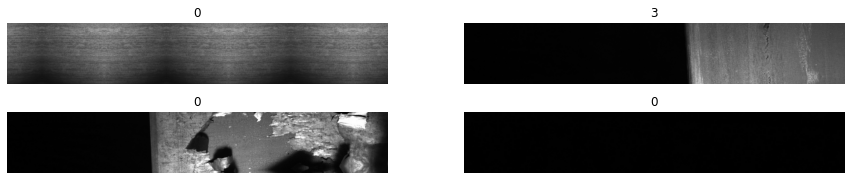

In [ ]:
dls.train.show_batch(figsize=(15, 3))

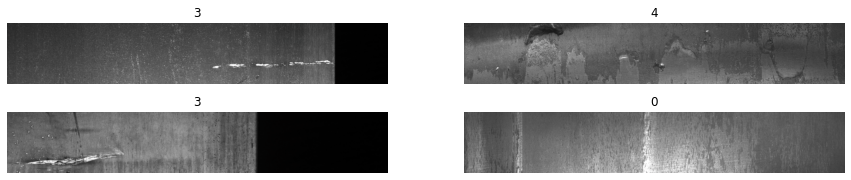

In [ ]:
dls.valid.show_batch(figsize=(15, 3))

In [ ]:
x, y = dls.train.one_batch()
x.shape, y.shape

((4, 3, 256, 1600), (4, 5))

## Segmentation

To get a `DataLoaders` object for training FastAI models, we need to: 
- load the training images
- load the corrisponding labels (saved in `labels_dir` by the `preprocessing` module with the `create_mask` function)
- pair the images with labels with a `Dataset`
- split the dataset into training and validation and pair them with a `Datasets` object.
- for each dataset, create a `DataLoader` with a batch size and pair them with a `DataLoaders` object.

In [ ]:
# export
classes = [0, 1, 2, 3, 4]

In [ ]:
#hide
size = (256,1600)

In [ ]:
btfms = aug_transforms(size=size)
btfms

[Flip -- {'size': (256, 1600), 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ]

In [ ]:
def get_x(df):
    img_name = df["ImageId"]
    return train_path / str(img_name)

def get_y(df):
    img_name = df["ImageId"].split(".")[0] + "_P.png"
    return labels_path / img_name

dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=classes)),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    batch_tfms=btfms)

Setting-up type transforms pipelines
0        0002cc93b.jpg             1
1        00031f466.jpg             0
2        000418bfc.jpg             0
3        000789191.jpg             0
4        0007a71bf.jpg             3
...                ...           ...
12563    fff0295e1.jpg             0
12564    fff02e9c5.jpg             3
12565    fffe98443.jpg             3
12566    ffff4eaa8.jpg             3
12567    ffffd67df.jpg             3

[12568 rows x 2 columns]
Found 12568 items
2 datasets of sizes 10055,2513
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> PILBase.create

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      ClassId
ImageId          0fac62a3e.jpg
ClassId_multi                0
Name: 761, dtype: object
    applying get_x gives
      ../data/train_images/0fac62a3e.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=1600x256
  Pipeline: get_y -> PILBase.create
    starting from
      ClassId
ImageId  

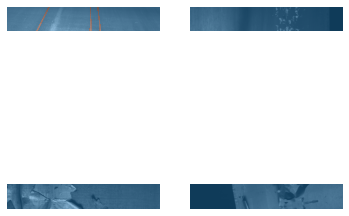

In [ ]:
dblock.summary(train_multi, show_batch=True)

In [ ]:
dsets = dblock.datasets(train_multi, verbose=True)

0        0002cc93b.jpg             1
1        00031f466.jpg             0
2        000418bfc.jpg             0
3        000789191.jpg             0
4        0007a71bf.jpg             3
...                ...           ...
12563    fff0295e1.jpg             0
12564    fff02e9c5.jpg             3
12565    fffe98443.jpg             3
12566    ffff4eaa8.jpg             3
12567    ffffd67df.jpg             3

[12568 rows x 2 columns]
Found 12568 items
2 datasets of sizes 10055,2513
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> PILBase.create


In [ ]:
t = dsets.train[-1]
t

(PILImage mode=RGB size=1600x256, PILMask mode=L size=1600x256)

In [ ]:
t_decoded = dsets.decode(t)
t_decoded

(PILImage mode=RGB size=1600x256, PILMask mode=L size=1600x256)

In [ ]:
dloader = dblock.dataloaders(train_multi, verbose=True)

0        0002cc93b.jpg             1
1        00031f466.jpg             0
2        000418bfc.jpg             0
3        000789191.jpg             0
4        0007a71bf.jpg             3
...                ...           ...
12563    fff0295e1.jpg             0
12564    fff02e9c5.jpg             3
12565    fffe98443.jpg             3
12566    ffff4eaa8.jpg             3
12567    ffffd67df.jpg             3

[12568 rows x 2 columns]
Found 12568 items
2 datasets of sizes 10055,2513
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> PILBase.create
Setting up after_item: Pipeline: AddMaskCodes -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': (256, 1600), 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}


In [ ]:
dloader.after_item

Pipeline: AddMaskCodes -> ToTensor

In [ ]:
dloader.before_batch

Pipeline: 

In [ ]:
dloader.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': (256, 1600), 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}

An example of pipeline:

In [ ]:
f = dloader.after_item
items = [f(dloader.create_item(i)) for i in range(4)]
items[0][0].shape, items[0][1].shape

((3, 256, 1600), (256, 1600))

In [ ]:
img_batch, mask_batch = dloader.do_batch([item for item in items])

img_batch.shape, mask_batch.shape

((4, 3, 256, 1600), (4, 256, 1600))

In [ ]:
batch[0][0, 0, :5, :5]

TensorImage([[ 50,  36,  31,  35,  39],
        [ 63,  45,  34,  33,  36],
        [ 73,  54,  37,  31,  33],
        [ 84,  66,  47,  36,  35],
        [100,  84,  62,  44,  38]], dtype=torch.uint8)

In [ ]:
img_tfbatch, mask_tfbatch = dloader.after_batch(batch)

In [ ]:
img_tfbatch[0, 0, :5, :5]

TensorImage([[0.2897, 0.2971, 0.2982, 0.2989, 0.2969],
        [0.2961, 0.3037, 0.3046, 0.3059, 0.3066],
        [0.3003, 0.2994, 0.3138, 0.3196, 0.3263],
        [0.3067, 0.3098, 0.3214, 0.3355, 0.3403],
        [0.3338, 0.3412, 0.3382, 0.3544, 0.3665]])

In [ ]:
mask_tfbatch.shape

(4, 256, 1600)

The `get_segmentation_dls` will load from the folder all the images while the `get_segmentation_dls_from_df` loads the images from a custom `DataFrame` to train on a different subsample.

In [ ]:
#export
def get_segmentation_dls(bs, size, with_btfms=True):
    """Dataloaders from `train_path` folder"""

    b_tfms = [Normalize.from_stats(*imagenet_stats)]

    if with_btfms:
        b_tfms += aug_transforms(
            size=size if size else (256, 1600),
            max_warp=0.,
            flip_vert=True,
            max_rotate=5.,
            max_lighting=0.1)

    def get_labels_from_img(p):
        return labels_path/f'{p.stem}_P.png'

    dblock = DataBlock(
        blocks=(ImageBlock, MaskBlock(codes=classes)),
        get_items=get_image_files,
        get_y=get_labels_from_img,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        batch_tfms=b_tfms)

    return dblock.dataloaders(train_path, bs=bs)

In [ ]:
# export
def get_segmentation_dls_from_df(train_df, bs, size):
    """Dataloaders from `train` DataFrame"""
    def get_x(df):
        img_name = df["ImageId"]
        return train_path / str(img_name)

    def get_y(df):
        img_name = df["ImageId"].split(".")[0] + "_P.png"
        return labels_path / img_name

    dblock = DataBlock(
        blocks=(ImageBlock, MaskBlock(codes=classes)),
        get_x=get_x,
        get_y=get_y,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        batch_tfms=aug_transforms(size=size))

    return dblock.dataloaders(train_df, bs=bs)

In [ ]:
# missing
bs = 4
szs = (128, 800)
dls = get_segmentation_dls_from_df(train_multi, bs, szs)

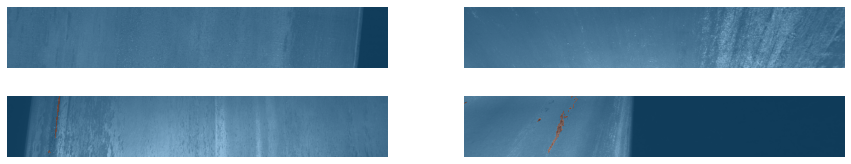

In [ ]:
dls.train.show_batch(figsize=(15, 3))

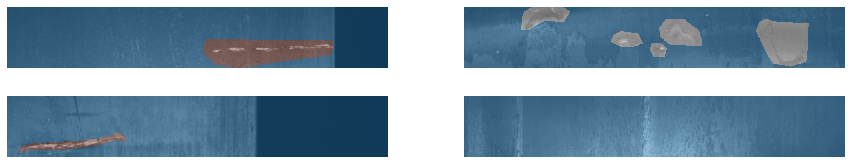

In [ ]:
dls.valid.show_batch(figsize=(15, 3))

In [ ]:
x, y = dls.train.one_batch()
x.shape, y.shape

((4, 3, 128, 800), (4, 128, 800))

In [ ]:
[torch.unique(y[i]) for i in range(bs)]

[TensorMask([0, 3]), TensorMask([0]), TensorMask([0]), TensorMask([0])]

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.ipynb.
Converted 02_dataset.ipynb.
Converted 04_model.metrics.ipynb.
Converted 05_models.unet.ipynb.
Converted 06_models.model.ipynb.
Converted index.ipynb.
